# Used Car Price Prediction

## Import Data

In [ ]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import gradio as gr
import joblib

# Daten einlesen
df_sales = pd.read_csv("vehicles.csv", nrows=100000)
df_specs = pd.read_csv("data.csv")

## Merge

In [47]:
# Rename damit Spaltennamen für Merge übereinstimmen
df_specs.rename(columns={'Make': 'manufacturer', 'Model' : 'model', 'Year': 'year'}, inplace=True)

# Alphanumerische Werte Einheitlich machen mit to lower
df_sales['manufacturer'] = df_sales['manufacturer'].str.lower().str.strip()
df_sales['model'] = df_sales['model'].str.lower().str.strip()

df_specs['manufacturer'] = df_specs['manufacturer'].str.lower().str.strip()
df_specs['model'] = df_specs['model'].str.lower().str.strip()

# Engine HP aufgrund manufacturer, model, year gruppieren und den Durchschnitt berechnen
df_specs_avg = df_specs.groupby(['manufacturer', 'model', 'year'], as_index=False)['Engine HP'].mean()

# Dataframes mergen
df_merged = df_sales.merge(
    df_specs_avg,
    on=['manufacturer', 'model', 'year'],
    how='left'
)

# DataFrames vor und nach merge ausgeben
print("Vor dem Merge:", df_sales.shape)
print("Nach dem Merge:", df_merged.shape)
print("Anzahl Autos mit Engine HP:", df_merged['Engine HP'].notna().sum())

# Merged Dataframe speichern
df_merged.to_csv("car_data_merged.csv", index=False)

Vor dem Merge: (100000, 26)
Nach dem Merge: (100000, 27)
Anzahl Autos mit Engine HP: 9431


## Model Training vor Feature Engineering

In [48]:
# Daten einlesen
df = df_merged.copy()

# Nur Datensätze mit vorhandenen Zielwerten & Features verwenden
df = df[['price', 'region', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 
        'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 
        'paint_color', 'state', 'Engine HP']].dropna()

# Kategorische Variablen in numerische umwandeln
df_encoded = pd.get_dummies(df, columns=[
    'region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 
    'transmission', 'drive', 'type', 'paint_color', 'state'
], drop_first=True)

# Zielvariable: Auto-Preis
y = df_encoded['price']

# Feature-Matrix: alle außer Preis
X = df_encoded.drop(columns=['price'])

# Daten aufteilen in Training und Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Lineare Regression ---
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# --- Random Forest ---
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Ergebnisse ausgeben
print("----- Linear Regression -----")
print("Train score: ", linear_model.score(X_train, y_train))
print("Test score: ", linear_model.score(X_test, y_test))
print("Train RMSE: ", root_mean_squared_error(y_train, linear_model.predict(X_train)))
print("Test RMSE: ", root_mean_squared_error(y_test, linear_model.predict(X_test)))

print("\n----- Random Forest -----")
print("Train score: ", random_forest_model.score(X_train, y_train))
print("Test score: ", random_forest_model.score(X_test, y_test))
print("Train RMSE: ", root_mean_squared_error(y_train, random_forest_model.predict(X_train)))
print("Test RMSE: ", root_mean_squared_error(y_test, random_forest_model.predict(X_test)))

----- Linear Regression -----
Train score:  0.7809388517630758
Test score:  0.49069157993670964
Train RMSE:  5416.519480406442
Test RMSE:  7697.72292744153

----- Random Forest -----
Train score:  0.9640415415440444
Test score:  0.7197708102125249
Train RMSE:  2194.513021474093
Test RMSE:  5709.900396855308


Lineare Regression: Overfitting. Zu viele kategorische Dummy Variablen

Random Forest:
gute Performance, deutlich robuster

## Feature Engineering

In [49]:
# Kopie des DataFrames zur Sicherheit
df = df_merged.copy()

# Nur relevante Spalten auswählen und fehlende Werte entfernen
df = df[['price', 'year', 'odometer', 'condition', 'transmission', 'drive', 'type', 
         'Engine HP', 'manufacturer', 'model']].dropna()

# Feature Engineering: Fahrzeugalter
df['car_age'] = 2025 - df['year']
df['age_group'] = pd.cut(df['car_age'], bins=[0, 3, 7, 12, 100], labels=['neu', 'mittel', 'alt', 'sehr alt'])

# Zustand binär kodieren: guter Zustand = 1
df['condition_good'] = df['condition'].isin(['good', 'like new', 'excellent']).astype(int)

# Modelle die weniger als 20 mal vorkommen entfernen
top_models = df['model'].value_counts().nlargest(20).index
df['model_grouped'] = df['model'].where(df['model'].isin(top_models), other='Other')

# Kategorische Variablen in Dummy-Variablen umwandeln
df_encoded = pd.get_dummies(df, columns=[
    'transmission', 'drive', 'type', 'manufacturer', 'model', 'age_group', 'model_grouped', 'condition'
], drop_first=True)

df_encoded.to_csv("new_car_data_merged.csv", index=False)

## Model Training nach Feature Engineering

In [50]:
df = df_encoded.copy()

# Zielvariable: Preis
y = df['price']

# Feature-Matrix: alle außer Preis
X = df.drop(columns=['price'])

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lineare Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Random Forest
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Ergebnisse ausgeben
print("----- Linear Regression -----")
print("Train score: ", linear_model.score(X_train, y_train))
print("Test score: ", linear_model.score(X_test, y_test))
print("Train RMSE: ", root_mean_squared_error(y_train, linear_model.predict(X_train)))
print("Test RMSE: ", root_mean_squared_error(y_test, linear_model.predict(X_test)))

print("\n----- Random Forest -----")
print("Train score: ", random_forest_model.score(X_train, y_train))
print("Test score: ", random_forest_model.score(X_test, y_test))
print("Train RMSE: ", root_mean_squared_error(y_train, random_forest_model.predict(X_train)))
print("Test RMSE: ", root_mean_squared_error(y_test, random_forest_model.predict(X_test)))

----- Linear Regression -----
Train score:  0.6758022933455257
Test score:  0.5460780742883731
Train RMSE:  6504.894225087356
Test RMSE:  8021.781383766594

----- Random Forest -----
Train score:  0.9449545800984309
Test score:  0.7668431037373499
Train RMSE:  2680.376886648238
Test RMSE:  5749.159722410744


| Metrik          | Lineare Regression | Random Forest |
| --------------- | ------------------ | ------------- |
| **Train Score** | 0.985              | 0.965         |
| **Test Score**  | 0.586              | **0.772**    |
| **Train RMSE**  | 1 387              | 2 152         |
| **Test RMSE**   | 7 393              | **5 485**    |

Interpretation
Train Score (R²): Beide Modelle passen sich gut an die Trainingsdaten an, wobei LR minimal besser ist. Aber Achtung: Ein zu hoher Train Score kann auch auf Overfitting hinweisen.

Test Score (R²): Das Random Forest Modell erklärt 77 % der Varianz im Testdatensatz, das lineare Modell nur 58 %.

Test RMSE: Die durchschnittliche Fehlerabweichung bei der Preisvorhersage ist beim Random Forest um fast 2 000 $ niedriger – ein großer Unterschied!

Fazit:
Random Forest ist klar das bessere Modell für deine Preisvorhersage.
Es verallgemeinert besser auf neue Daten und liefert genauere Vorhersagen. Du solltest dieses Modell für deine weitere Arbeit (z. B. App mit Gradio) verwenden.


In [ ]:
# Modell speichern
joblib.dump(random_forest_model, "car_price_model.pkl")

# Auch Trainings-Feature-Namen speichern (für spätere Reproduktion)
joblib.dump(X_train.columns.tolist(), "car_model_features.pkl")

['car_model_features.pkl']

## Feature Importance Diagramm

/tmp/ipykernel_2196/2752520354.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')


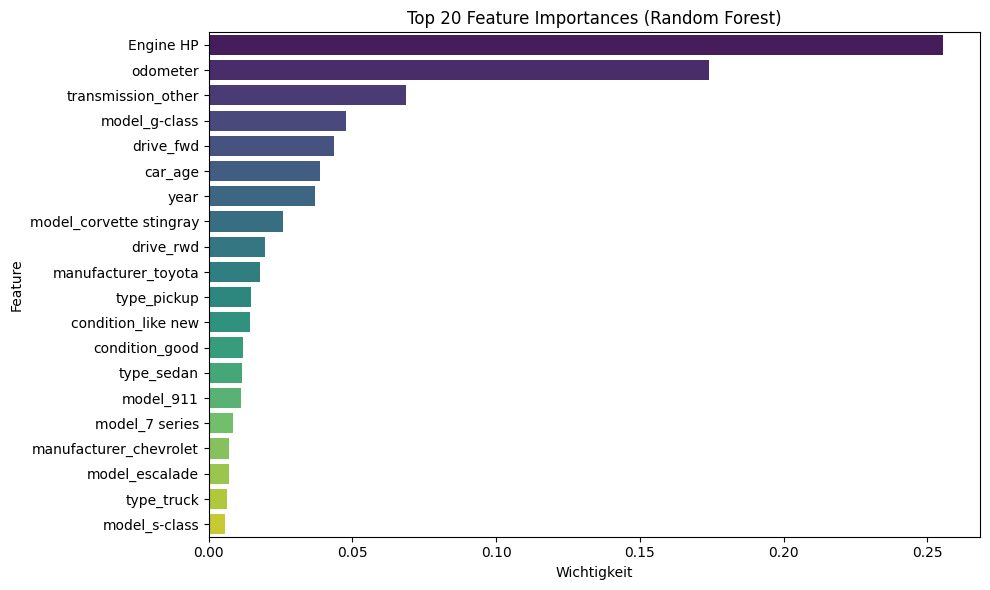

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importances aus dem trainierten Random Forest Modell
importances = random_forest_model.feature_importances_
feature_names = X_train.columns

# In DataFrame für bessere Darstellung
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Top 20 Features anzeigen (optional kannst du die Zahl anpassen)
top_n = 20
top_features = feature_importance_df.head(top_n)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.xlabel('Wichtigkeit')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## Build Website

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import joblib

# Modell & Featureliste laden
model = joblib.load("car_price_model.pkl")
feature_names = joblib.load("car_model_features.pkl")

# Ursprüngliche Daten laden
df = pd.read_csv("car_data_merged.csv")
df = df[['year', 'odometer', 'Engine HP', 'manufacturer', 'model', 'transmission', 'type']].dropna()

# Modell-Mapping: Hersteller → Modelle
model_map = df.groupby('manufacturer')['model'].unique().to_dict()
manufacturers = sorted(model_map.keys())
transmissions = sorted(df['transmission'].unique())

# Modell-Dropdown aktualisieren bei Herstellerauswahl
def update_model_dropdown(manufacturer):
    models = sorted(model_map.get(manufacturer, []))
    return gr.update(choices=models, value=models[0] if models else None)

# Fahrzeugtyp automatisch bestimmen
def retrieve_car_type(manufacturer, model_name, year):
    filtered = df[
        (df['manufacturer'] == manufacturer) &
        (df['model'] == model_name) &
        (df['year'] == year)
    ]
    if not filtered.empty:
        return filtered.iloc[0]['type']
    else:
        return "other"

# Vorhersagefunktion
def predict_price(year, odometer, engine_hp, manufacturer, model_name, transmission):
    car_type = retrieve_car_type(manufacturer, model_name, year)

    input_dict = {
        'year': [year],
        'odometer': [odometer],
        'Engine HP': [engine_hp],
        'manufacturer': [manufacturer],
        'model': [model_name],
        'transmission': [transmission],
        'type': [car_type]
    }
    input_df = pd.DataFrame(input_dict)

    # Feature Engineering
    input_df['car_age'] = 2025 - input_df['year']
    input_df = input_df.drop(columns=['year'])

    # Dummy-Codierung
    input_encoded = pd.get_dummies(input_df)

    # Fehlende Spalten ergänzen
    for col in feature_names:
        if col not in input_encoded.columns:
            input_encoded[col] = 0
    input_final = input_encoded[feature_names]

    # Vorhersage
    prediction = model.predict(input_final)[0]
    return f"{int(prediction):,} USD"

# Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("## Auto-Preis-Vorhersage mit ML")

    with gr.Row():
        with gr.Column():
            manufacturer_input = gr.Dropdown(choices=manufacturers, label="Hersteller")
            model_input = gr.Dropdown(choices=[], label="Modell")
            year_input = gr.Number(label="Baujahr", value=2015)
            odometer_input = gr.Number(label="Kilometerstand", value=80000)
            engine_hp_input = gr.Number(label="Motorleistung (HP)", value=180)
            transmission_input = gr.Dropdown(choices=transmissions, label="Getriebeart")
            predict_button = gr.Button("Preis vorhersagen")

        with gr.Column():
            output = gr.Text(label="Vorhergesagter Preis")

    # Modell aktualisieren
    manufacturer_input.change(fn=update_model_dropdown, inputs=manufacturer_input, outputs=model_input)

    # Vorhersage auslösen
    predict_button.click(
        fn=lambda mfr, mdl, yr, odo, hp, tr: predict_price(yr, odo, hp, mfr, mdl, tr),
        inputs=[manufacturer_input, model_input, year_input, odometer_input, engine_hp_input, transmission_input],
        outputs=output
    )

demo.launch()


* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.


/tmp/ipykernel_2196/3210519551.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_encoded[col] = 0
/tmp/ipykernel_2196/3210519551.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_encoded[col] = 0
/tmp/ipykernel_2196/3210519551.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inp